작성된 내용은 아래 출처에서 data만 변경하여 진행된 내용입니다.
  + 출처1 : https://www.tidytextmining.com/sentiment.html
  + 출처2 : https://statkclee.github.io/text/nlp-sentiment.html#-

# 영문 text에 대한 감정분석

+ 목적 : 만들어진 (영문)감정사전을 이용하여, 각 text에 들어있는 단어별로 감정 분포 확인
+ 한계 : 한 단어 기준으로 가능하며, 합성어(2~3개의 단어 조합) 및 문장에 대한 감정분류/분포는 확인이 용의하지 않음

+ Index
  1. **자료 확보/정제**<br/>
     1.1.자료 불러오기<br/>
     1.2.자료 형식 확인<br/>
     <br/>
  2. **token화**<br/>
     2.1. 깔끔한 텍스트(tidytext) 변환 <br/>
     2.2. token 결과 비교<br/>
     <br/>
  3. **Text 에서의 감정 분석**<br/>
     3.1. 전체 Text 감정분류<br/>
     3.2. 각 TITLE별 감성 변화 추이(Trend)<br/>
     3.3. 특정 TITLE 내에서의 감성 분포<br/>
     3.4. TITLE 별 특정 감정에 대한 분포 비교<br/>
     <br/>
(참조) 영문 사전 비교


In [52]:
# 0. 환경설정 ------------------------------

# if (!require("devtools")) install.packages("devtools")
# devtools::install_github("ropenscilabs/gutenbergr")

# if (!require("gutenbergr")) install.packages("gutenbergr")
# if (!require("tidyverse")) install.packages("tidyverse")
# if (!require("DT")) install.packages("DT")
# if (!require("stringr")) install.packages("stringr")
# if (!require("tidytext")) install.packages("tidytext")
# if (!require("ggthemes")) install.packages("ggthemes")
# if (!require("extrafont")) install.packages("extrafont")

library(gutenbergr)
library(tidyverse)
library(DT)
library(stringr)
library(tidytext)
library(ggthemes)
library(extrafont)

loadfonts()


### 1.자료 확보/정제

In [53]:
## 1.1.자료 불러오기 -------------------

#-- 자료설명을 위해, CS자료까지 추가하되, 별도 공개하지 않음 --#
books <- read.csv(file="text_emotion_eng_v2.csv")

###정상 load 확인
tail(books)

,TITLE,text
194899,Kaggle,I spent time with my daughter.
194900,Kaggle,My husband announced he is getting a decent bonus for this quarter.
194901,Kaggle,Had a can of Pepsi to drink.
194902,Kaggle,Cuddling with my girlfriend last night.
194903,Kaggle,I had a great meeting yesterday at work with my boss and a few colleagues and we went out for lunch afterward; everybody was excited by the projects we're working on and how efficient our team is.
194904,Kaggle,I had a great workout last night.


In [54]:
## 1.2.자료 형식 확인 -------------------

#-- tidytext 함수 이용을 위해, character 형식으로 변경 --#
#-- 대/소문자 구분 주의! --#

books$text  <- as.character(books$text)
books$TITLE <- as.character(books$TITLE)

str(books)

'data.frame':	194904 obs. of  2 variables:
 $ TITLE: chr  "IBM" "IBM" "IBM" "IBM" ...
 $ text : chr  "@tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[" "Layin n bed with a headache  ughhhh...waitin on your call..." "Funeral ceremony...gloomy friday..." "wants to hang out with friends SOON!" ...


In [55]:
## 1.2.항목별 text Line 수 확인 -------------------

#-- 해당 count값이 문장수를 의미하지 않음 --#
#-- 소설자료의 경우, 임의로 줄바꿈이 있음 --#

books %>% 
    count(TITLE)

TITLE,n
CS_2017Y,41339
IBM,40000
Kaggle,100535
Pride and Prejudice,13030


### 2.token화

In [56]:
# 2.1. 깔끔한 텍스트(tidytext) 변환 ---------

tidy_books <- books %>% 
    group_by(TITLE) %>% 
    mutate(linenumber = row_number()) %>% 
    unnest_tokens(word, text) %>% 
    ungroup()

In [57]:
# 2.2. token 결과 비교 ---------
#- token화 전 -#
tail(books,1)

,TITLE,text
194904,Kaggle,I had a great workout last night.


In [59]:
#- token화 후 -#
tail(tidy_books,7)

TITLE,linenumber,word
Kaggle,100535,i
Kaggle,100535,had
Kaggle,100535,a
Kaggle,100535,great
Kaggle,100535,workout
Kaggle,100535,last
Kaggle,100535,night


### 3.Text 에서의 감정 분석

Joining, by = "word"


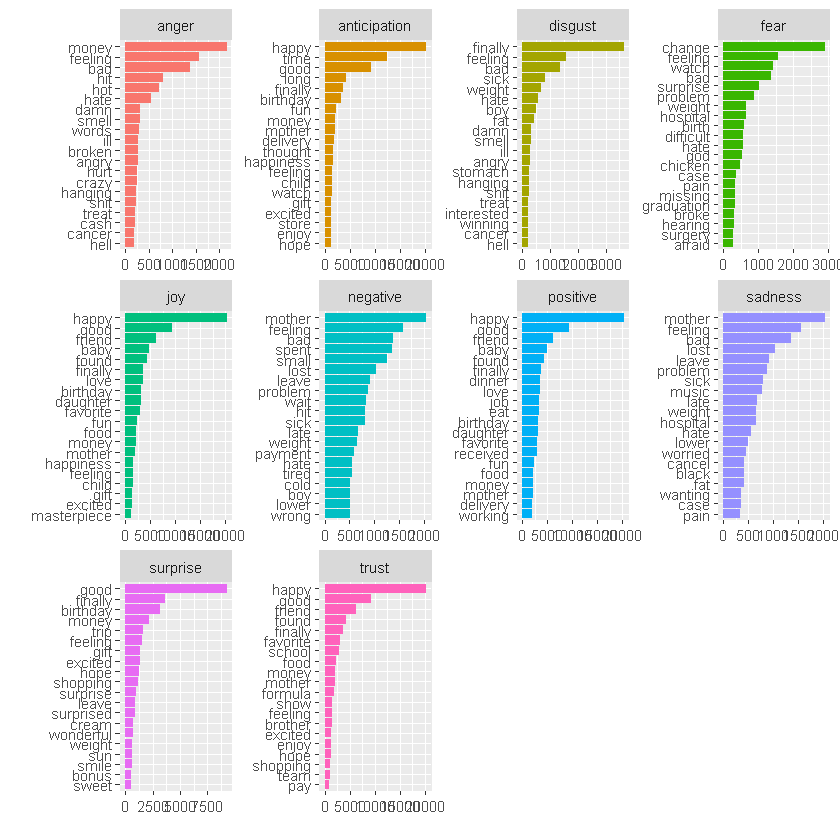

In [68]:
# 3. 감성 분석 ------------------------------------
## 3.1. 전체 Text 감정분류 ------------------------

#- token화 한 결과에 대해, 합산/정리 -# 
#- nrc 사전을 이용하여, 10개 감정으로 분류 -# 
word_counts <- tidy_books %>% 
    inner_join(get_sentiments("nrc")) %>% 
    count(word, sentiment)

#- 위에서 합산/정리된 결과 중, 상위 20개만 추출/재배열함 -# 
top_words <- word_counts %>% 
    group_by(sentiment) %>% 
    top_n(20, n) %>% 
    ungroup() %>% 
    mutate(word = reorder(word, n))

#- 상위 20개 결과에 대해 plot chart 그리기 -# 
ggplot(top_words, aes(word, n, fill = sentiment)) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~sentiment, scales = "free") +  
    coord_flip() +
    labs(x="", y="")

In [76]:
## 3.2. 각 TITLE별 감성 변화 추이(Trend) -------------

#- bing사전을 이용하여, 긍정-부정 감정에 대한 분류 -# 
#- 임의의 문장(여기서는 10개의 row)을 합쳐, 이를 한 문장으로 봄 -# 
#- 감정 = 긍정단어 겟수 - 부정단어 겟수로 정의함 -#

tidy_books_score <- tidy_books %>%
    inner_join(get_sentiments("bing")) %>%
    count(TITLE, index = linenumber %/% 10, sentiment) %>%
    spread(sentiment, n, fill = 0) %>%
    mutate(sentiment = positive - negative)

tail(tidy_books_score,2)


Joining, by = "word"


TITLE,index,negative,positive,sentiment
Pride and Prejudice,1301,4,2,-2
Pride and Prejudice,1302,4,6,2


Joining, by = "word"


ERROR: Error: Don't know how to add RHS to a theme object


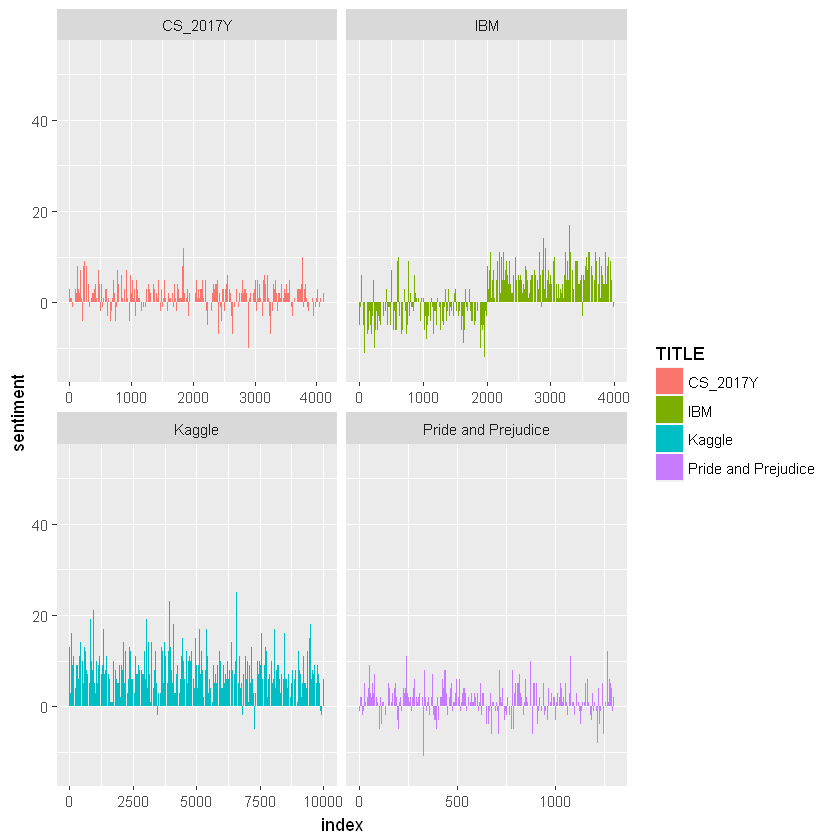

In [77]:
tidy_books %>%
    inner_join(get_sentiments("bing")) %>%
    count(TITLE, index = linenumber %/% 10, sentiment) %>%
    spread(sentiment, n, fill = 0) %>%
    mutate(sentiment = positive - negative) %>%
    ggplot(aes(index, sentiment, fill=TITLE)) +
    geom_col() +
    facet_wrap(~TITLE, scales ="free_x") 
    theme_bw(base_family = "NanumGothic") +
    theme(legend.position = "none") +
    labs(x="", y="감성점수", fill="책제목")

Joining, by = "word"
Joining, by = "word"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"윈도우즈 폰트데이터베이스에서 찾을 수 없는 폰트페밀리입니다"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"윈도우즈 폰트데이터베이스에서 찾을 수 없는 폰트페밀리입니다"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"윈도우즈 폰트데이터베이스에서 찾을 수 없는 폰트페밀리입니다"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"윈도우즈 폰트데이터베이스에서 찾을 수 없는 폰트페밀리입니다"

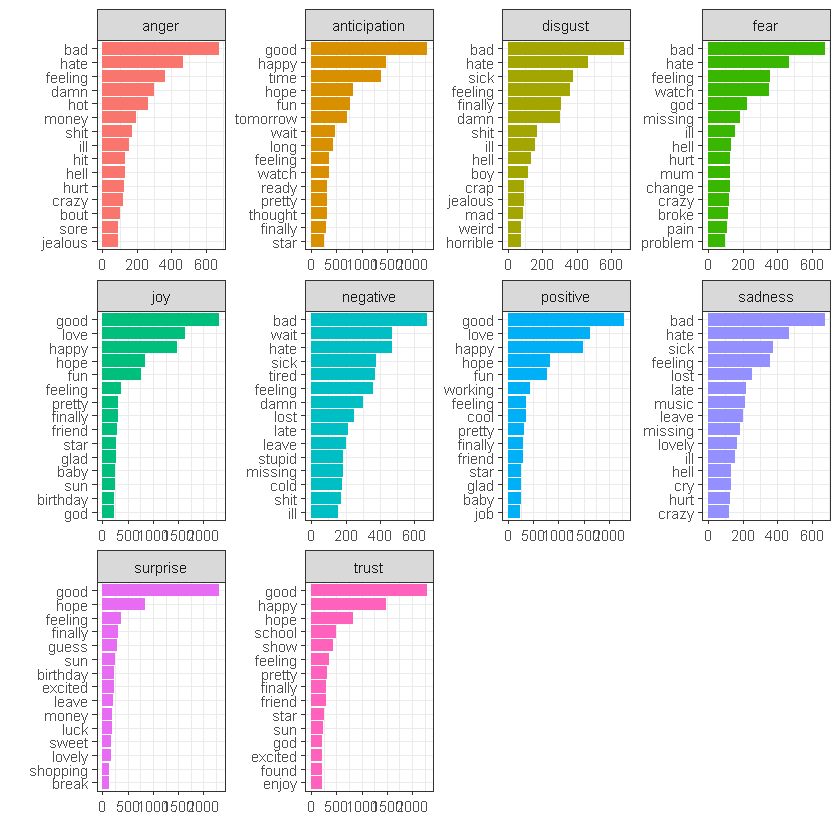

In [62]:
## 3.3. 특정 TITLE 내에서의 감성 분포 -------------
# IBM 자료에 대해, 감정별 단어 확인

books_cs <- subset(books,books$TITLE == 'IBM')

tidy_books_cs <- books_cs %>% 
    group_by(TITLE) %>% 
    mutate(linenumber = row_number()) %>% 
    unnest_tokens(word, text) %>% 
    ungroup()

tidy_books_cs %>%
    anti_join(data_frame(word ="usher")) %>% 
    inner_join(get_sentiments("nrc")) %>%
    count(word, sentiment) %>%
    group_by(sentiment) %>%
    top_n(15, n) %>%
    ungroup() %>%
    mutate(word = reorder(word, n)) %>%
    ggplot(aes(word, n, fill=sentiment)) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ sentiment, scales = "free") +
    coord_flip() +
    theme_bw(base_family = "NanumGothic") +
    theme(legend.position = "none") +
    labs(x="", y="", fill="책제목")

Joining, by = "word"
Joining, by = "word"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"윈도우즈 폰트데이터베이스에서 찾을 수 없는 폰트페밀리입니다"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"윈도우즈 폰트데이터베이스에서 찾을 수 없는 폰트페밀리입니다"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"윈도우즈 폰트데이터베이스에서 찾을 수 없는 폰트페밀리입니다"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"윈도우즈 폰트데이터베이스에서 찾을 수 없는 폰트페밀리입니다"

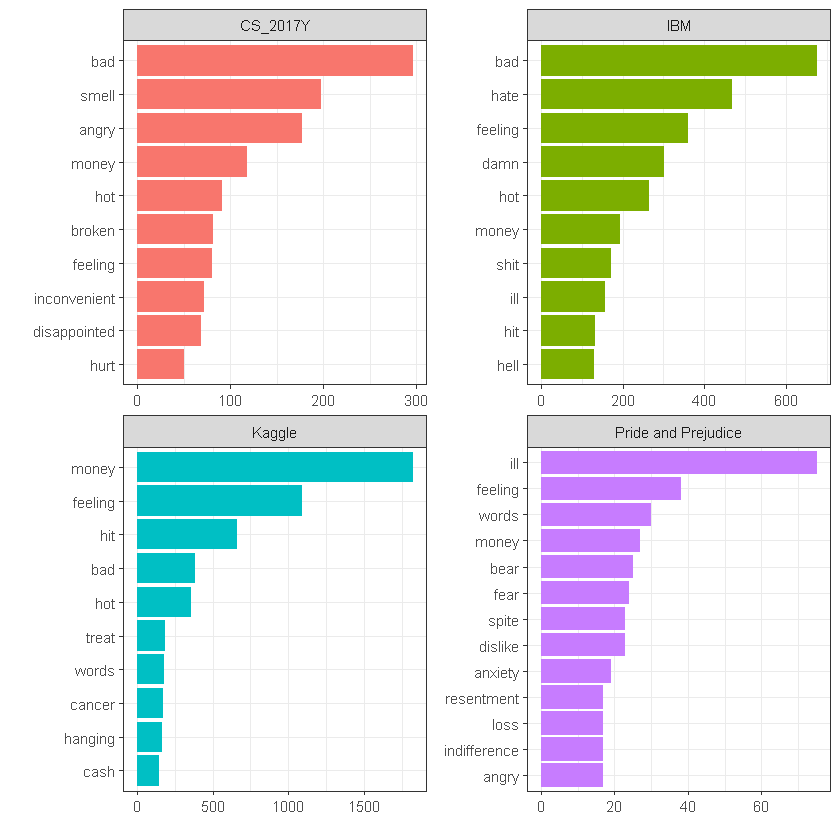

In [64]:
## 3.4. TITLE 별 특정 감정에 대한 분포 비교 ---------------------
# nrc 사전 기준, anger만 비교

tidy_books %>%
    anti_join(data_frame(word ="usher")) %>% 
    inner_join(get_sentiments("nrc")) %>%
    filter(sentiment %in% c("anger")) %>% 
    count(word, TITLE) %>%
    group_by(TITLE) %>%
    top_n(10, n) %>%
    ungroup() %>%
    mutate(word = reorder(paste(word, TITLE, sep = "__"), n)) %>%
    ggplot(aes(word, n, fill=TITLE)) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ TITLE, scales = "free") +
    coord_flip() +
    theme_bw(base_family = "NanumGothic") +
    theme(legend.position = "top") +
    labs(x="", y="", fill="책제목") +
    scale_x_discrete(labels = function(x) str_replace_all(x, "__.+$", ""))

### (참조) 영문 사전 비교

In [85]:
## 1. afinn 사전  ------------------------
### NEG/POS에 대해, -5~5 사이의 값을 부여

print(get_sentiments("afinn"))

# A tibble: 2,476 x 2
   word       score
   <chr>      <int>
 1 abandon       -2
 2 abandoned     -2
 3 abandons      -2
 4 abducted      -2
 5 abduction     -2
 6 abductions    -2
 7 abhor         -3
 8 abhorred      -3
 9 abhorrent     -3
10 abhors        -3
# ... with 2,466 more rows


In [86]:
## 2. bing 사전  ------------------------
### NEG/POS에 대한 구분만 진행
print(get_sentiments("bing"))

# A tibble: 6,788 x 2
   word        sentiment
   <chr>       <chr>    
 1 2-faced     negative 
 2 2-faces     negative 
 3 a+          positive 
 4 abnormal    negative 
 5 abolish     negative 
 6 abominable  negative 
 7 abominably  negative 
 8 abominate   negative 
 9 abomination negative 
10 abort       negative 
# ... with 6,778 more rows


In [87]:
## 3. nrc 사전  ------------------------
### 10가지 감정 구분
print(get_sentiments("nrc"))

# A tibble: 13,901 x 2
   word        sentiment
   <chr>       <chr>    
 1 abacus      trust    
 2 abandon     fear     
 3 abandon     negative 
 4 abandon     sadness  
 5 abandoned   anger    
 6 abandoned   fear     
 7 abandoned   negative 
 8 abandoned   sadness  
 9 abandonment anger    
10 abandonment fear     
# ... with 13,891 more rows
